# A notebook for exploring how best to measure the change in Mtb

In [3]:
import napari
from cellpose import models
from macrohet import dataio, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)

from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools, visualise

### Load all metadata

Both the image metadata and the assay layout metadata

In [2]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [5]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(os.path.join(base_dir, 
                                                f'labels/macrohet_seg_model/{row,column}.h5'), 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/06/07 11:49:44 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2023/06/07 11:49:44 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:49:44 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:49:44 AM] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/06/07 11:49:45 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 4).h5
[INFO][2023/06/07 11:49:45 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2023/06/07 11:49:45 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:49:45 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:49:45 AM] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2023/06/07 11:49:46 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 5).h5
[INFO][2023/06/07 11:49:46 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2023/06/07 11:49:46 AM] Loading tracks/obj_type_1
[INFO]

[INFO][2023/06/07 11:50:02 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 5).h5
[INFO][2023/06/07 11:50:02 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2023/06/07 11:50:02 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:50:02 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:50:02 AM] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2023/06/07 11:50:03 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 6).h5
[INFO][2023/06/07 11:50:03 AM] Opening HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2023/06/07 11:50:03 AM] Loading tracks/obj_type_1
[INFO][2023/06/07 11:50:03 AM] Loading LBEP/obj_type_1
[INFO][2023/06/07 11:50:03 AM] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2023/06/07 11:50:05 AM] Closing HDF file: /mnt/DATA/macrohet/labels/macrohet_seg_model/(6, 7).h5
[INFO][2023/06/07 11:50:05 AM] Opening HDF file: /mnt/DATA/macrohe

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import tools

def create_track_dictionary(track, info):
    """
    Create a dictionary of track information for a single track.
    
    Parameters:
    - track (dict): Track information dictionary
    - info (Series): Assay layout info for the track
    
    Returns:
    - dict: Dictionary containing track information
    """
    # Raw MTB values (interpolated)
    raw_mtb_values = pd.Series(track['mean_intensity'][:, 1]).interpolate(method='linear')
    
    # Raw GFP values (interpolated)
    raw_gfp = pd.Series(track['mean_intensity'][:, 0]).interpolate(method='linear')
    
    # Thresholded MTB values (interpolated)
    mtb_values = pd.Series(track['mean_intensity'][:, 2]).interpolate(method='linear')
    
    # Smoothed MTB signal using a rolling window of 4 with median values,
    # then backfilling missing values at the start
    mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill'))
    
    # Interpolate other variables using appropriate methods
    minor_axis_length = pd.Series(track['minor_axis_length']).interpolate(method='linear')
    major_axis_length = pd.Series(track['major_axis_length']).interpolate(method='linear')
    
    # Interpolate infection status using a combination of approaches
    infection_status = pd.Series(track['Infected'])
    
    # If the first value is missing, assign it the closest infection value
    if pd.isnull(infection_status.iloc[0]):
        infection_status.iloc[0] = infection_status.iloc[infection_status.first_valid_index()]
    
    # Fill subsequent missing values with the previous value
    infection_status = infection_status.fillna(method='ffill')
    
    # Interpolate area based on linear method
    area = pd.Series(track['area']).interpolate(method='linear')
    
    # Compile single track dictionary of info
    d = {
        'Time (hours)': track['t'],                                      # Time (hours)
        'x': track['x'],                                                  # x
        'y': track['y'],                                                  # y
        'x scaled': [track['x'][i] * 5.04 for i, x in enumerate(track['x'])],    # x scaled
        'y scaled': [track['y'][i] * 5.04 for i, y in enumerate(track['y'])],    # y scaled
        'Infection status': track['Infected'],                            # Infection status
        'Initial infection status': track['Infected'][0],                # Initial infection status
        'Final infection status': track['Infected'][-1],                 # Final infection status
        'Area': track['area'],                                            # Area
        'Intracellular mean Mtb content': raw_mtb_values,                 # Intracellular mean Mtb content
        'Intracellular thresholded Mtb content': mtb_values,              # Intracellular thresholded Mtb content
        'Intracellular thresholded Mtb content smooth': mtb_smooth,       # Intracellular thresholded Mtb content smooth
        'Macroph. GFP expression': raw_gfp,                               # Macroph. GFP expression
        'delta Mtb raw': [np.array(mtb_values)[-1] - np.array(mtb_values)[0] for i in range(len(track))],   # delta Mtb raw
        'delta Mtb max raw': [(max(mtb_values) - min(mtb_values)) * (1 if np.argmax(mtb_values) > np.argmin(mtb_values) else -1) for i in range(len(track))],   # delta Mtb max raw
        'delta Mtb max smooth': [(max(mtb_smooth) - min(mtb_smooth)) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) for i in range(len(track))],   # delta Mtb max smooth
        'delta Mtb max fold-change': [max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],   # delta Mtb max fold-change
        'delta Mtb max fold-change normalised mean area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.mean(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],   # delta Mtb max fold-change normalised mean area
        'delta Mtb max fold-change normalised max area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth > 0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1)) / np.max(area) if np.any(mtb_smooth > 0) else 0 for i in range(len(track))],   # delta Mtb max fold-change normalised max area
        'delta Mtb/dt': np.polyfit(np.arange(len(mtb_smooth)), mtb_smooth, 1)[0],   # delta Mtb/dt
        'Eccentricity': np.sqrt(1 - ((minor_axis_length ** 2) / (major_axis_length ** 2))),   # Eccentricity
        'MSD': [tools.euc_dist(track['x'][i - 1], track['y'][i - 1], track['x'][i], track['y'][i]) if i != 0 else 0 for i in range(0, len(track))],   # MSD
        'Strain': [info['Strain'] for i in range(len(track['t']))],     # Strain
        'Compound': [info['Compound'] for i in range(len(track['t']))], # Compound
        'Concentration': [info['ConcentrationEC'] for i in range(len(track['t']))],  # Concentration
        'Cell ID': [track.ID for i in range(len(track['t']))],          # Cell ID
        'Acquisition ID': [key for i in range(len(track['t']))],         # Acquisition ID
        'Unique ID': [f'{track.ID}.{key[0]}.{key[1]}' for i in range(len(track['t']))]    # Unique ID
    }
    
    return d


# List to store individual track DataFrames
dfs = []

# Dictionary to store filtered tracks
filtered_tracks = {}

# Iterate over all tracks
for key in tqdm(tracks_dict.keys()):
    # Extract tracks only with a maximum length greater than 40
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) > 40]
    
    # Iterate over full length tracks
    for track in filtered_tracks[key]:
        # Get assay layout info
        info = assay_layout.loc[key]
        
        # Create track dictionary
        d = create_track_dictionary(track, info)
        
        # Append DataFrame to list of DataFrames
        dfs.append(pd.DataFrame(d))

# Concatenate individual track DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)


In [56]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tqdm(tracks_dict.keys()):
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) >40] #== 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        # raw mtb 
        raw_mtb_values = pd.Series(track['mean_intensity'][:, 1],).interpolate(method='linear')
        # raw gfp
        raw_gfp = pd.Series(track['mean_intensity'][:, 0]).interpolate(method='linear')
        ### mtb values (remove nan by linear interpolation)
        mtb_values = pd.Series(track['mean_intensity'][:, 2]).interpolate(method='linear')
        ### smooth mtb signal by using a rolling window of 4 with median values then backfill the missing values at the start
        mtb_smooth = np.array(mtb_values.rolling(window=4).median().interpolate(method='backfill',))
        # interpolate other variables using appropriate method for each var 
        minor_axis_length =  pd.Series(track['minor_axis_length']).interpolate(method='linear')
        major_axis_length =  pd.Series(track['major_axis_length']).interpolate(method='linear')
        # interpolating infection status using a combination of approaches
        infection_status = pd.Series(track['Infected'])
        # If the first value is missing, then assign it the closest infection value
        if pd.isnull(infection_status.iloc[0]):
            infection_status.iloc[0] = infection_status.iloc[infection_status.first_valid_index()]
        # Otherwise filling subsequent missing values with the previous value
        infection_status = infection_status.fillna(method='ffill')
        # interpolate area based on linear
        area = pd.Series(track['area']).interpolate(method='linear')
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'x scaled':[track['x'][i]*5.04 for i, x in enumerate(track['x'])],
             'y scaled':[track['y'][i]*5.04 for i, y in enumerate(track['y'])],
             'Infection status':track['Infected'],
             'Initial infection status':track['Infected'][0], 
             'Final infection status':track['Infected'][-1], 
             'Area':track['area'], 
             'Intracellular mean Mtb content':raw_mtb_values,
             'Intracellular thresholded Mtb content':mtb_values,
             'Intracellular thresholded Mtb content smooth':mtb_smooth,
             'Macroph. GFP expression':raw_gfp,
              # calculates the total change over all time
             'delta Mtb raw': [np.array(mtb_values)[-1] - np.array(mtb_values)[0] 
                               for i in range(len(track))],
             # calculates the maximum change over all time and calibrates it as an increase or decrease
             'delta Mtb max raw': [(max(mtb_values) - min(mtb_values)) * (1 if np.argmax(mtb_values) > np.argmin(mtb_values) else -1) for i in range(len(track))],
             # calcaultes the same as above but for smooth values
             'delta Mtb max smooth': [(max(mtb_smooth) - min(mtb_smooth)) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) for i in range(len(track))],
             ### this one calculate the fold change of the minimum non zero value (indicating the cell is infected)
             'delta Mtb max fold-change': [max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1) if np.any(mtb_smooth>0) else 0 for i in range(len(track)) ],
             'delta Mtb max fold-change normalised mean area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1))/np.mean(area) if np.any(mtb_smooth>0) else 0 for i in range(len(track))],
             'delta Mtb max fold-change normalised max area': [(max(mtb_smooth) / min(mtb_smooth[mtb_smooth>0]) * (1 if np.argmax(mtb_smooth) > np.argmin(mtb_smooth) else -1))/np.max(area) if np.any(mtb_smooth>0) else 0 for i in range(len(track))],
             'delta Mtb/dt': np.polyfit(np.arange(len(mtb_smooth)), mtb_smooth, 1)[0],
             'Eccentricity':np.sqrt(1-((minor_axis_length**2)/(major_axis_length**2))),
             'MSD': [tools.euc_dist(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))], 
             'Unique ID': [f'{track.ID}.{key[0]}.{key[1]}' for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

  0%|          | 0/24 [00:00<?, ?it/s]

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


In [58]:
# Save to pickle format
df.to_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl')

# Save to CSV format
df.to_csv('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.csv', index=False)

In [15]:
df = pd.read_csv('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.csv')

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,NaN,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,NaN,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,NaN,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,NaN,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,NaN,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,NaN,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,NaN,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,NaN,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,NaN,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


In [60]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_>40.pkl')
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb max fold-change normalised max area,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.095232,0.418707,0.813310,0.000000,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
1,1,725.449097,73.245003,3656.263447,369.154814,0.0,0.0,1.0,48727.0,362.852478,...,0.095232,0.418707,0.896474,17.860383,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
2,2,723.088928,76.431496,3644.368198,385.214738,0.0,0.0,1.0,43484.0,363.515442,...,0.095232,0.418707,0.876911,3.965367,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
3,3,726.009766,79.395073,3659.089219,400.151168,0.0,0.0,1.0,39113.0,360.448578,...,0.095232,0.418707,0.717504,4.161019,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
4,4,728.209656,82.197769,3670.176665,414.276757,0.0,0.0,1.0,32644.0,362.289764,...,0.095232,0.418707,0.425791,3.562951,RD1,CTRL,EC0,433,"(3, 4)",433.3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701474,70,757.886719,44.412071,3819.749063,223.836839,1.0,1.0,1.0,71808.0,358.460327,...,-0.000019,-0.092227,0.923363,0.522451,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701475,71,760.801514,49.459522,3834.439629,249.275992,1.0,1.0,1.0,65328.0,358.026184,...,-0.000019,-0.092227,0.893735,5.828618,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701476,72,761.494873,50.097046,3837.934160,252.489111,1.0,1.0,1.0,66829.0,358.846039,...,-0.000019,-0.092227,0.888738,0.941904,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9
701477,73,759.911255,48.538654,3829.952725,244.634818,1.0,1.0,1.0,71877.0,358.451752,...,-0.000019,-0.092227,0.897926,2.221808,WT,BDQ,EC99,2320,"(6, 9)",2320.6.9


### Renaming delta Mtb method of choice for ease of use

In [61]:
df['dMtb'] = df['delta Mtb max fold-change normalised max area']

# Style

In [178]:
sns.set(font='Nimbus Sans', style = 'white')

### Old style

In [8]:
sns.color_palette('PiYG')

[(0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.9348712033833141, 0.6798154555940021, 0.8312187620146096),
 (0.9856978085351787, 0.9031910803537101, 0.9458669742406767),
 (0.9202614379084968, 0.9629373317954633, 0.8576701268742792),
 (0.6908881199538641, 0.8624375240292197, 0.4883506343713959),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

In [9]:
colors = ['#013220',#'#008B8B',#(0.204*0.8, 0.330*0.8, 0.706*0.8), 
          sns.color_palette('PiYG')[0], sns.color_palette('PiYG')[-1]]
colors

['#013220',
 (0.8129181084198386, 0.2544405997693195, 0.5693194925028835),
 (0.38269896193771624, 0.6403690888119954, 0.18108419838523643)]

### New style

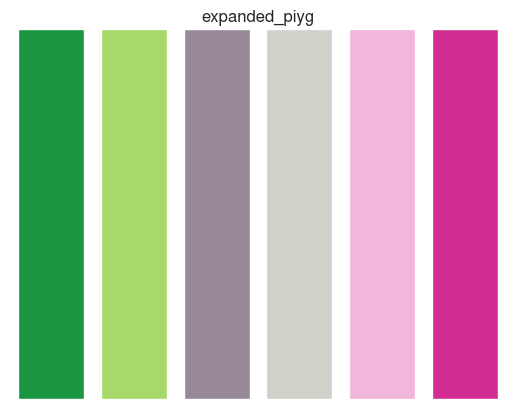

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [179]:
# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)


# Output

In [11]:
output_dir = '/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/'
os.makedirs(output_dir, exist_ok = True)

### Quick plot to show variation to atb response

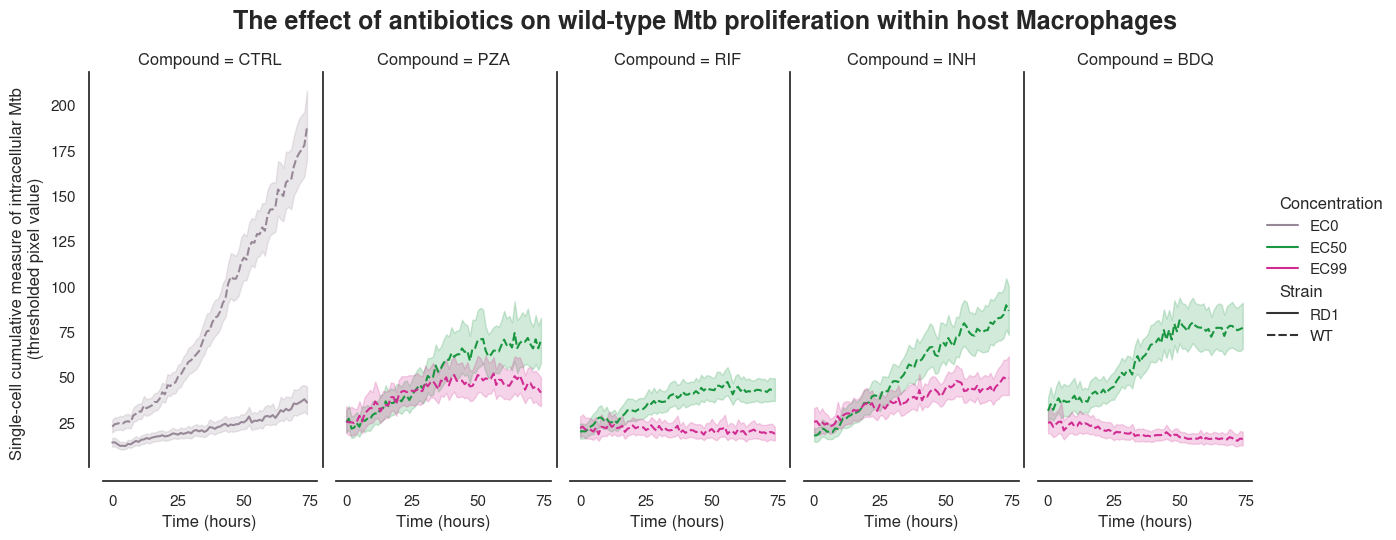

In [78]:
g = sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular thresholded Mtb content', 
            hue = 'Concentration', 
            style = 'Strain',
            col= 'Compound',
            kind = 'line',
            aspect = 0.5,
            palette=[ expanded_piyg[2], expanded_piyg[0],  expanded_piyg[-1],]
           )
# # g.set_ylabels("Intracellular Mtb content")
# g.set_ylabels("Intracellular $\\mathit{Mycobacterium tuberculosis}$")
# plt.gcf().suptitle('The effect of antibiotics on wild-type **$\\mathit{Mycobacterium tuberculosis}$** (Mtb) proliferation within host Macrophages', 
#                    fontsize=14, fontweight='bold', 
#                   y = 1.05)
# plt.rc('text', usetex=False)
# g.set_ylabels("Intracellular Mtb content")
g.set_ylabels("Single-cell cumulative measure of intracellular Mtb \n (thresholded pixel value)")
plt.gcf().suptitle('The effect of antibiotics on wild-type Mtb proliferation within host Macrophages', 
                   fontsize=18, fontweight='bold', 
                  y = 1.05)
plt.rc('text', usetex=False)
sns.despine(offset = 10)
plt.savefig(os.path.join(output_dir, 'ATB_effect_Mtb.png'), bbox_inches = 'tight', dpi = 314)

# How many cells are truly permissive ie deltaMtb>0

#### What do the different distributions of deltaMtb look like?

In [63]:
df_delta_mtb = df.drop_duplicates(subset=['delta Mtb raw', 'delta Mtb max raw','delta Mtb max smooth', 'delta Mtb max fold-change'])
df_delta_mtb

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb
0,0,708.125061,77.589088,3568.950308,391.049006,0.0,0.0,1.0,42556.0,365.408905,...,0.418707,0.813310,0.0,RD1,CTRL,EC0,433,"(3, 4)",433.3.4,0.095232
42,0,261.683105,4.945100,1318.882852,24.923306,0.0,0.0,0.0,6754.0,355.006958,...,-0.142246,0.913146,0.0,RD1,CTRL,EC0,424,"(3, 4)",424.3.4,-0.000112
89,0,349.589508,8.074520,1761.931121,40.695581,0.0,0.0,0.0,13672.0,344.202454,...,0.000000,0.957093,0.0,RD1,CTRL,EC0,425,"(3, 4)",425.3.4,0.000000
152,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,0.346945,0.929721,0.0,RD1,CTRL,EC0,426,"(3, 4)",426.3.4,0.000586
226,0,663.630920,10.924337,3344.699839,55.058660,0.0,0.0,0.0,20098.0,353.067780,...,0.031179,0.805467,0.0,RD1,CTRL,EC0,427,"(3, 4)",427.3.4,0.000544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701271,33,660.136597,577.060730,3327.088447,2908.386079,0.0,0.0,0.0,47448.0,377.264587,...,-0.000397,0.952213,0.0,WT,BDQ,EC99,2297,"(6, 9)",2297.6.9,0.000032
701313,33,224.372467,131.369995,1130.837234,662.104775,1.0,1.0,1.0,98867.0,373.245178,...,0.050624,0.885194,0.0,WT,BDQ,EC99,2292,"(6, 9)",2292.6.9,-0.000153
701355,33,1106.007935,1032.619019,5574.279990,5204.399854,0.0,0.0,1.0,53641.0,366.914032,...,0.366863,0.950100,0.0,WT,BDQ,EC99,2286,"(6, 9)",2286.6.9,0.000089
701397,34,477.689026,538.676697,2407.552690,2714.930552,0.0,0.0,0.0,36503.0,356.196930,...,0.374870,0.796381,0.0,WT,BDQ,EC99,2324,"(6, 9)",2324.6.9,0.000167


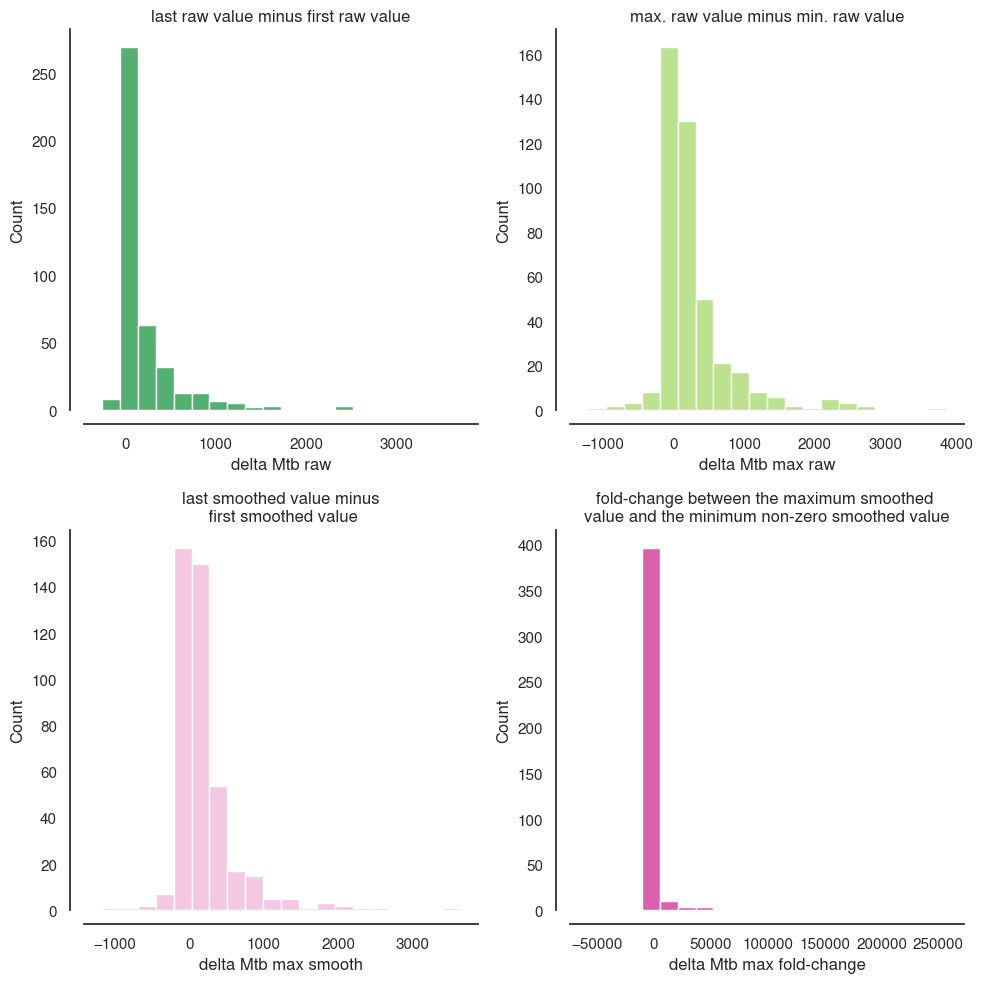

In [389]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb raw', kde=False, ax=axes[0, 0], bins = 20, color=expanded_piyg[0])
axes[0, 0].set_title('last raw value minus first raw value')
# axes[0, 0].set_ylim([0, 300])  # set the ylim for the first subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max raw', kde=False, ax=axes[0, 1], bins = 20, color=expanded_piyg[1])
axes[0, 1].set_title('max. raw value minus min. raw value')
# axes[0, 1].set_ylim([0, 300])  # set the ylim for the second subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max smooth', kde=False, ax=axes[1, 0], bins = 20, color=expanded_piyg[-2])
axes[1, 0].set_title('last smoothed value minus\n first smoothed value')
# axes[1, 0].set_ylim([0, 300])  # set the ylim for the third subplot

sns.histplot(data=df_delta_mtb[df_delta_mtb['Acquisition ID']==(3,5)], x='delta Mtb max fold-change', kde=False, ax=axes[1, 1], bins = 20, color=expanded_piyg[-1])
axes[1, 1].set_title('fold-change between the maximum smoothed \nvalue and the minimum non-zero smoothed value')
# axes[1, 1].set_ylim([0, 100])  # set the ylim for the fourth subplot

sns.despine(offset=10)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_approach_hist_unclipped_3,5.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 


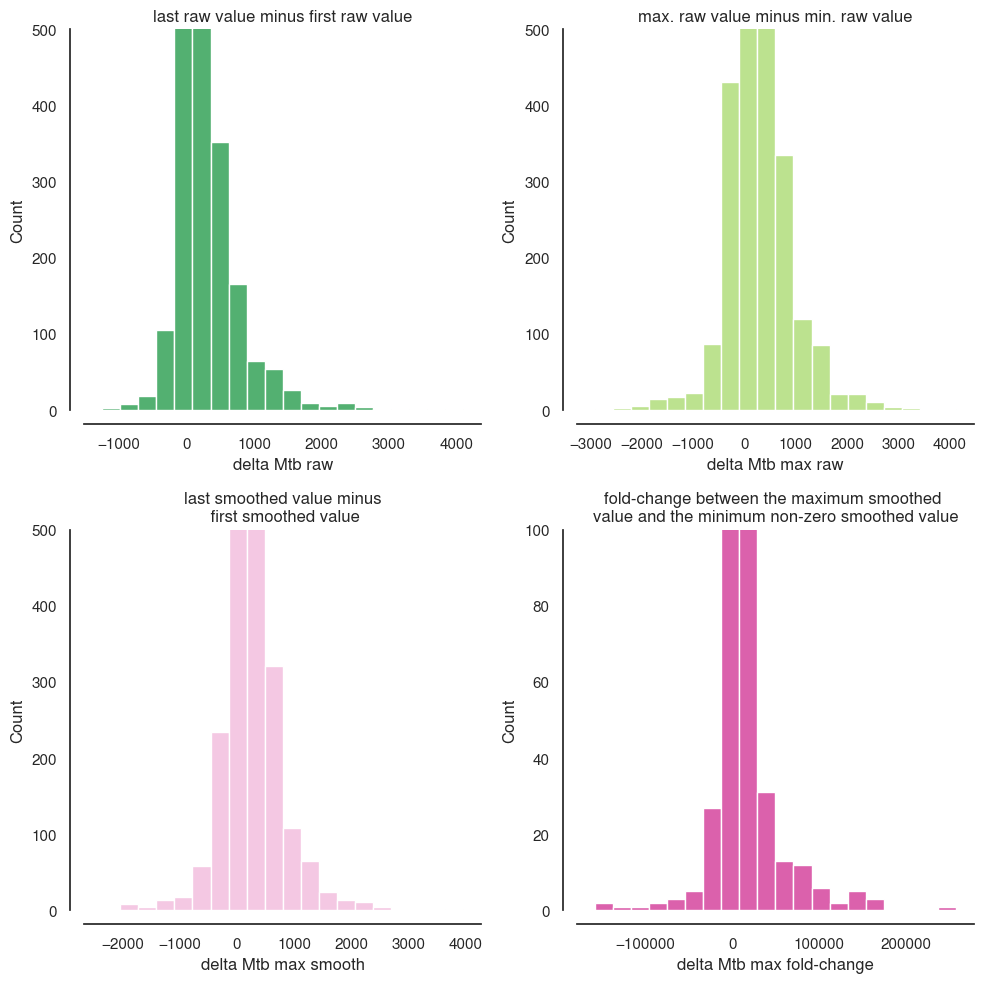

In [384]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

sns.histplot(data=df_delta_mtb, x='delta Mtb raw', kde=False, ax=axes[0, 0], bins = 20, color=expanded_piyg[0])
axes[0, 0].set_title('last raw value minus first raw value')
axes[0, 0].set_ylim([0, 500])  # set the ylim for the first subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max raw', kde=False, ax=axes[0, 1], bins = 20, color=expanded_piyg[1])
axes[0, 1].set_title('max. raw value minus min. raw value')
axes[0, 1].set_ylim([0, 500])  # set the ylim for the second subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max smooth', kde=False, ax=axes[1, 0], bins = 20, color=expanded_piyg[-2])
axes[1, 0].set_title('last smoothed value minus\n first smoothed value')
axes[1, 0].set_ylim([0, 500])  # set the ylim for the third subplot

sns.histplot(data=df_delta_mtb, x='delta Mtb max fold-change', kde=False, ax=axes[1, 1], bins = 20, color=expanded_piyg[-1])
axes[1, 1].set_title('fold-change between the maximum smoothed \nvalue and the minimum non-zero smoothed value')
axes[1, 1].set_ylim([0, 100])  # set the ylim for the fourth subplot

sns.despine(offset=10)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_approach_hist_clipped.png'), 
           bbox_inches = 'tight', dpi = 314)

plt.show() 


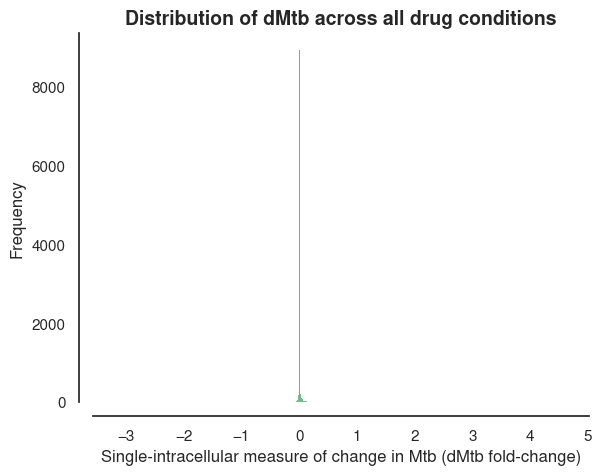

In [145]:

sns.histplot(data=df_delta_mtb, x='dMtb', kde=False, bins = 400, color=expanded_piyg[0])
sns.despine(offset=10)
# plt.ylim(0,2000)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
#            bbox_inches = 'tight', dpi = 314)
plt.ylabel('Frequency')
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_conditions.png', 
           bbox_inches = 'tight', dpi = 314)
plt.show() 

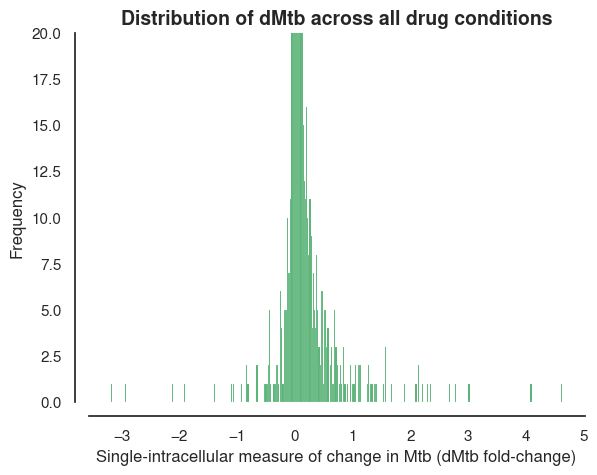

In [148]:
sns.histplot(data=df_delta_mtb, x='dMtb', kde=False, bins = 400, color=expanded_piyg[0])
sns.despine(offset=10)
plt.ylim(0,20)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# plt.savefig(os.path.join(output_dir, 'single-cell_signal/delta_mtb_considerations/delta_mtb_norm_hist_clipped.png'), 
#            bbox_inches = 'tight', dpi = 314)
plt.ylabel('Frequency')
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_conditions_clipped.png', 
           bbox_inches = 'tight', dpi = 314)
plt.show() 

In [207]:
# "Melt" the DataFrame to "long-form" or "tidy" representation
df_melted = pd.melt(df_delta_mtb, ["Compound", "Concentration"], var_name="measurement")
df_melted = df_melted[df_melted['measurement'] == 'dMtb']
# Rename the 'value' column to 'dMtb'
df_melted = df_melted.rename(columns={'value': 'dMtb'})



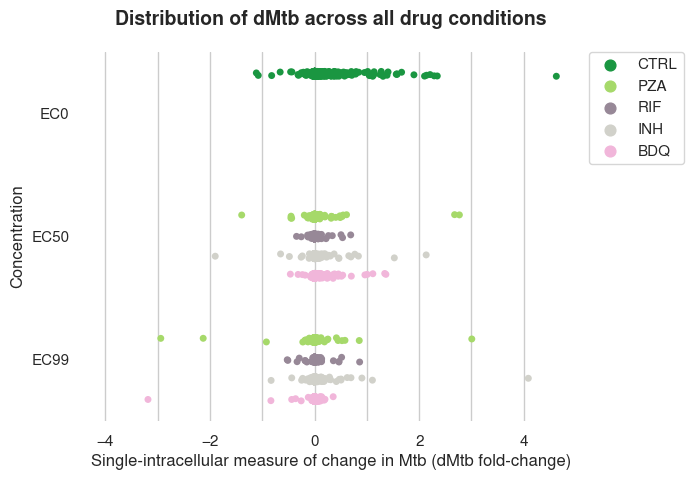

In [299]:
# Initialize the figure
f, ax = plt.subplots()


# Show each observation with a scatterplot
sns.stripplot(
    data=df_melted, x="dMtb", y="Concentration", hue="Compound",
    dodge=True, alpha=1, zorder=5, ax=ax, palette = expanded_piyg
)

# Move the legend outside the plot on the right-hand side
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
sns.despine(offset=10, 
            bottom=True, 
            left=True
           )
# # Show the conditional means using pointplot
# sns.pointplot(
#     data=df_melted, x="dMtb", y="Concentration", hue="Compound",
#     join=False, 
#     dodge=.8 - .8 / len(df_delta_mtb['Compound'].unique()), 
#     palette=expanded_piyg,
#     markers="d", scale=.75, errorbar=None, ax=ax, legend = None
# )
# Add vertical lines
vertical_lines = np.linspace(-4,4, 9)  # Example values, modify according to your needs
for line in vertical_lines:
    plt.axvline(x=line, color='black', linestyle='-', linewidth=1, alpha = 0.2)
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# Show the plot
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_scatter.png', 
#            bbox_inches = 'tight', dpi = 314)
plt.show() 

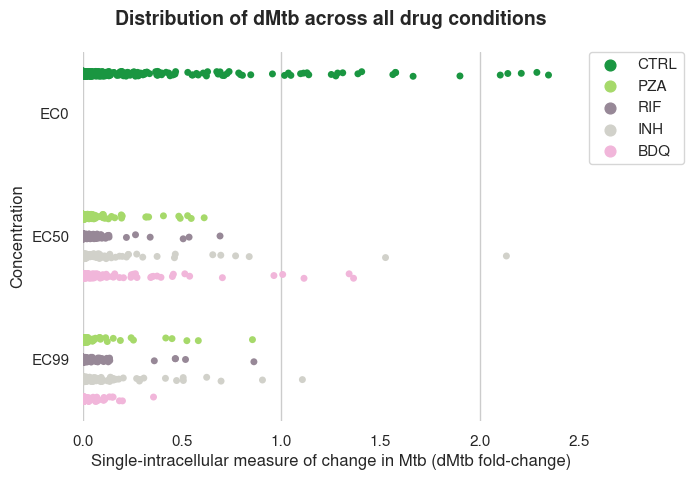

In [304]:
# Initialize the figure
f, ax = plt.subplots()


# Show each observation with a scatterplot
sns.stripplot(
    data=df_melted, x="dMtb", y="Concentration", hue="Compound",
    dodge=True, alpha=1, zorder=5, ax=ax, palette = expanded_piyg
)

# Move the legend outside the plot on the right-hand side
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
sns.despine(offset=10, 
            bottom=True, 
            left=True
           )
# # Show the conditional means using pointplot
# sns.pointplot(
#     data=df_melted, x="dMtb", y="Concentration", hue="Compound",
#     join=False, 
#     dodge=.8 - .8 / len(df_delta_mtb['Compound'].unique()), 
#     palette=expanded_piyg,
#     markers="d", scale=.75, errorbar=None, ax=ax, legend = None
# )
# Add vertical lines
# vertical_lines = np.linspace(-4,4, 9)  # Example values, modify according to your needs
for line in vertical_lines:
    plt.axvline(x=line, color='black', linestyle='-', linewidth=1, alpha = 0.2)
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
plt.xlim(0, 2.5)
# Show the plot
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_scatter.png', 
#            bbox_inches = 'tight', dpi = 314)
plt.show() 

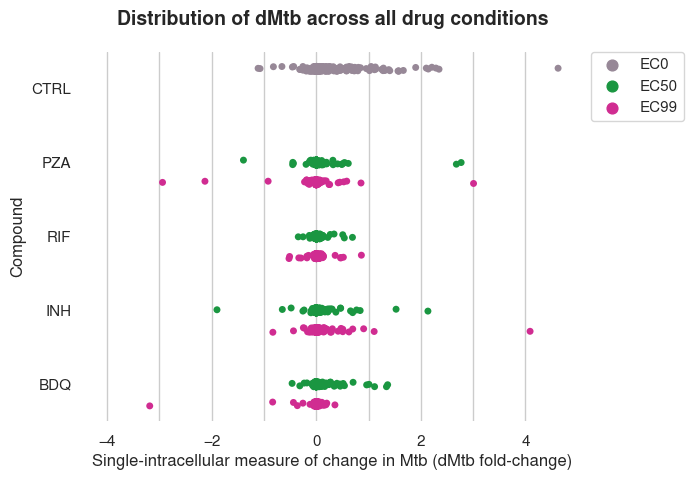

In [291]:
# Initialize the figure
f, ax = plt.subplots()


# Show each observation with a scatterplot
sns.stripplot(
    data=df_melted, x="dMtb", y="Compound", hue="Concentration",
    dodge=True, alpha=1, zorder=5, ax=ax, palette = [expanded_piyg[2], expanded_piyg[0], expanded_piyg[-1]]
)

# Move the legend outside the plot on the right-hand side
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
sns.despine(offset=10, 
            bottom=True, 
            left=True
           )

# Add vertical lines
vertical_lines = np.linspace(-4,4, 9)  # Example values, modify according to your needs
for line in vertical_lines:
    plt.axvline(x=line, color='black', linestyle='-', linewidth=1, alpha = 0.2)
plt.title('Distribution of dMtb across all drug conditions', 
                   fontsize=14, fontweight='bold', 
                  y = 1.05)
plt.xlabel('Single-intracellular measure of change in Mtb (dMtb fold-change)')
# Show the plot
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/cumulative_sc_plots/thresholded_480_jun23/dmtb/dmtb_all_drug_scatter_alt.png', 
           bbox_inches = 'tight', dpi = 314)
plt.show() 

In [214]:
# Assuming 'df_delta_Mtb' is your DataFrame
top_rows = df_delta_mtb.nlargest(10, 'dMtb')
top_rows

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,delta Mtb/dt,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Unique ID,dMtb
41983,0,519.976685,1041.591919,2620.682490,5249.623271,0.0,0.0,1.0,33191.0,370.089539,...,8.268794,0.696256,0.0,WT,CTRL,EC0,280,"(3, 5)",280.3.5,4.624052
657222,0,388.780487,668.168152,1959.453655,3367.567485,0.0,0.0,1.0,23630.0,363.540588,...,11.490217,0.810668,0.0,WT,INH,EC99,96,"(6, 8)",96.6.8,4.088434
613711,18,195.733536,157.711990,986.497020,794.868431,0.0,0.0,0.0,39243.0,379.313904,...,-1.144762,0.915205,0.0,WT,PZA,EC99,1925,"(6, 6)",1925.6.6,3.007196
69880,0,883.031555,1056.135254,4450.479038,5322.921680,1.0,1.0,1.0,12569.0,377.961823,...,89.769524,0.658125,0.0,WT,PZA,EC50,299,"(3, 6)",299.3.6,2.769864
77597,7,180.348572,225.591080,908.956802,1136.979042,1.0,1.0,1.0,16899.0,387.806305,...,8.437622,0.819995,0.0,WT,PZA,EC50,1251,"(3, 6)",1251.3.6,2.678517
36197,0,933.322388,697.360840,4703.944834,3514.698633,0.0,0.0,1.0,18897.0,377.389099,...,11.976203,0.827378,0.0,WT,CTRL,EC0,106,"(3, 5)",106.3.5,2.346850
34092,0,1013.018066,613.704102,5105.611055,3093.068672,0.0,0.0,1.0,33571.0,390.042694,...,6.309599,0.856875,0.0,WT,CTRL,EC0,484,"(3, 5)",484.3.5,2.288280
34737,0,907.020264,626.401550,4571.382129,3157.063813,0.0,0.0,1.0,14859.0,380.547668,...,9.452961,0.487975,0.0,WT,CTRL,EC0,539,"(3, 5)",539.3.5,2.209745
391455,0,723.685181,491.966370,3647.373311,2479.510503,0.0,0.0,1.0,18043.0,371.835907,...,4.397746,0.787266,0.0,WT,CTRL,EC0,525,"(5, 5)",525.5.5,2.141826
136595,1,692.762024,1189.384521,3491.520601,5994.497988,0.0,0.0,1.0,16521.0,362.497620,...,12.065323,0.655386,0.0,WT,INH,EC50,724,"(3, 8)",724.3.8,2.134655


Text(10, 500, 'Gradient of Mtb = 8.268794172508796')

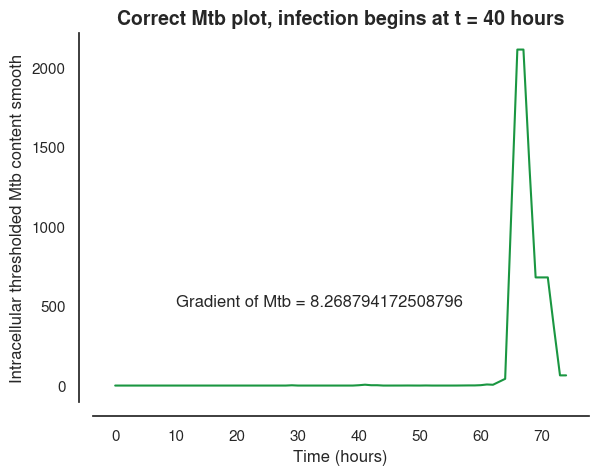

In [150]:
unique_ID = '280.3.5'
sns.lineplot(data = df[df['Unique ID']==unique_ID], y = 'Intracellular thresholded Mtb content smooth', x = 'Time (hours)')
sns.despine(offset=10)
plt.title('Correct Mtb plot, infection begins at t = 40 hours', 
                   fontsize=14, fontweight='bold', )
#                   y = 1.05)
gradient = df[df['Unique ID']==unique_ID]['delta Mtb/dt'].iloc[0]
plt.text(x = 10, y = 500, s = f'Gradient of Mtb = {gradient}')
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/jun23_error/correct_{unique_ID}_cell_ID_switch_mtb_plot.png', 
#            bbox_inches = 'tight', dpi = 314)

### Many sc

In [275]:
top_rows =df_delta_mtb.nlargest(7, 'dMtb')

In [281]:
subset_df.dMtb.iloc[0]

2.288280132472997

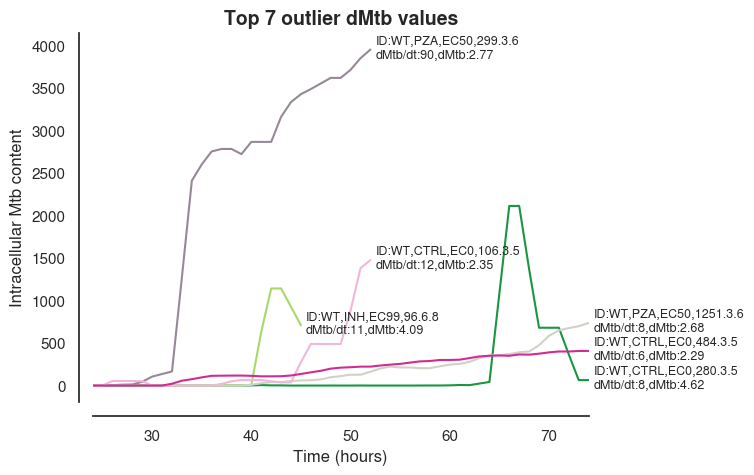

In [303]:
for i, unique_ID in enumerate(top_rows['Unique ID']):
    subset_df = df[df['Unique ID']==unique_ID]
    strain = subset_df['Strain'].iloc[0]
    compound = subset_df['Compound'].iloc[0]
    concentration = subset_df['Concentration'].iloc[0]
    ID = subset_df['Unique ID'].iloc[0]
    label = f'{strain},{compound},{concentration},{ID}'
#     label = f'{ID}'

    gradient = subset_df['delta Mtb/dt'].iloc[0]
    if gradient<0:
        continue
    x,y = subset_df['Time (hours)'].iloc[-1], subset_df['Intracellular thresholded Mtb content smooth'].iloc[-1]
    plt.text(x = x+0.5, y = y-100, s = f'ID:{label}\ndMtb/dt:{gradient:.0f},dMtb:{subset_df.dMtb.iloc[0]:.2f}', size =9)

    sns.lineplot(data = subset_df, 
                 y = 'Intracellular thresholded Mtb content smooth', 
                 x = 'Time (hours)', 
#                  label = label
                 )
sns.despine(offset=10)
plt.title('Top 7 outlier dMtb values', 
               fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.ylabel('Intracellular Mtb content')
plt.xlim(24,74)
# plt.text(x = 10, y = 500, s = f'Gradient of Mtb = {gradient}')
plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/jun23_dmtb_outliers/top7_dmtb_plot.png', 
           bbox_inches = 'tight', dpi = 314)

In [275]:
top_rows =df_delta_mtb.nlargest(7, 'dMtb')

In [281]:
subset_df.dMtb.iloc[0]

2.288280132472997

(0.0, 500.0)

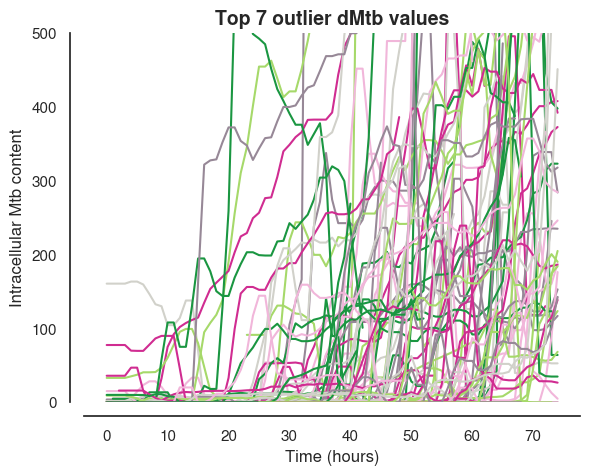

In [308]:
top_rows =df_delta_mtb.nlargest(100, 'dMtb')
for i, unique_ID in enumerate(top_rows['Unique ID']):
    subset_df = df[df['Unique ID']==unique_ID]
    strain = subset_df['Strain'].iloc[0]
    compound = subset_df['Compound'].iloc[0]
    concentration = subset_df['Concentration'].iloc[0]
    ID = subset_df['Unique ID'].iloc[0]
    label = f'{strain},{compound},{concentration},{ID}'
    label = f'{ID}'

    gradient = subset_df['delta Mtb/dt'].iloc[0]
    if gradient<0:
        continue
    x,y = subset_df['Time (hours)'].iloc[-1], subset_df['Intracellular thresholded Mtb content smooth'].iloc[-1]
#     plt.text(x = x+0.5, y = y-100, s = f'ID:{label}\ndMtb/dt:{gradient:.0f},dMtb:{subset_df.dMtb.iloc[0]:.2f}', size =9)

    sns.lineplot(data = subset_df, 
                 y = 'Intracellular thresholded Mtb content smooth', 
                 x = 'Time (hours)', 
#                  label = label
                 )
sns.despine(offset=10)
plt.title('Top 7 outlier dMtb values', 
               fontsize=14, fontweight='bold', )
#                   y = 1.05)
plt.ylabel('Intracellular Mtb content')
plt.ylim(0,500)
# plt.text(x = 10, y = 500, s = f'Gradient of Mtb = {gradient}')
# plt.savefig(f'/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_graphs/jun23_dmtb_outliers/top7_dmtb_plot.png', 
#            bbox_inches = 'tight', dpi = 314)